# Clustering Summary

## Setup

Choose the results file you wish to explore from the list below.

Result files are created automatically by `clustering.py` script,
with date and timestamp from the experiment finish appended to the filename.

In [1]:
# data files and results are stored in the same hdfs folder:
import pyarrow
pyarrow.hdfs.connect().ls('hdfs:///data/')

['/data/df_3-shingles_sparse-binary-vectors.parquet',
 '/data/df_3-shingles_sparse-count-vectors.parquet',
 '/data/df_4-shingles_sparse-binary-vectors.parquet',
 '/data/df_4-shingles_sparse-count-vectors.parquet',
 '/data/df_5-shingles_sparse-binary-vectors.parquet',
 '/data/df_5-shingles_sparse-count-vectors.parquet',
 '/data/results-20200414-143442.parquet',
 '/data/uniprot-proteome_UP000005640.tab']

In [2]:
# set this to your results file:
RESULTS_FILENAME = 'results-20200414-143442.parquet'

## Exploring results

First, we load the data and extract information about experiment features.

Experiment results are small enough, so we use pandas and pyarrow to store them in memory.
If necessary, they can be configured to work on spark dataframes (see their respective documentation).

In [3]:
?pd.Series.str.contains

Object `pd.Series.str.contains` not found.


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import re

def convert_model(x):
    if 'clustering.KMeans' in x:
        return 'KMeans'
    elif 'clustering.BisectingKMeans' in x:
        return 'BisectingKMeans'
    else:
        return None

def get_shingles(x):
    n_shingles = re.findall(r'\d+', x)[0]
    return int(n_shingles)

df = pd.read_parquet(f'hdfs:///data/{RESULTS_FILENAME}')
df['model'] = df['model'].apply(convert_model)
df['n_shingles'] = df['in_file'].apply(get_shingles)
df['binary_vectors'] = df['in_file'].str.contains('binary-vectors')
df['sparse'] = df['in_file'].str.contains('sparse')
df.sort_values(by='silhouette_cost', inplace=True, ascending=False)
df.head()

,in_file,distance,k,model,has_distance_cost,silhouette_cost,distance_cost,min_cluster_size,max_cluster_size,mean_cluster_size,has_log_likelihoodlog_likelihood,_12,n_shingles,binary_vectors,sparse
397,/data/df_5-shingles_sparse-count-vectors.parquet,euclidean,2,BisectingKMeans,True,0.998141,1.449471e+07,39,74670,37354.5,False,0.0,5,False,True
396,/data/df_5-shingles_sparse-count-vectors.parquet,euclidean,2,KMeans,True,0.998141,1.449471e+07,39,74670,37354.5,False,0.0,5,False,True
108,/data/df_3-shingles_sparse-count-vectors.parquet,euclidean,2,KMeans,True,0.997329,4.052747e+07,39,74771,37405.0,False,0.0,3,False,True
252,/data/df_4-shingles_sparse-count-vectors.parquet,euclidean,2,KMeans,True,0.997045,3.108652e+07,39,74771,37405.0,False,0.0,4,False,True
253,/data/df_4-shingles_sparse-count-vectors.parquet,euclidean,2,BisectingKMeans,True,0.997045,3.108652e+07,39,74771,37405.0,False,0.0,4,False,True


We make a backup of the data to local fs on master node, so that it can be downloaded and examined after the cluster is shut down.

In [5]:
df.to_csv(f'{RESULTS_FILENAME}.csv', header=True, index=False)

### Choosing optimal number of clusters

Number of clusters is the most important hyperparameter.

First, we look at the silhouette scores (we want to choose the hyperparameters with highest score).

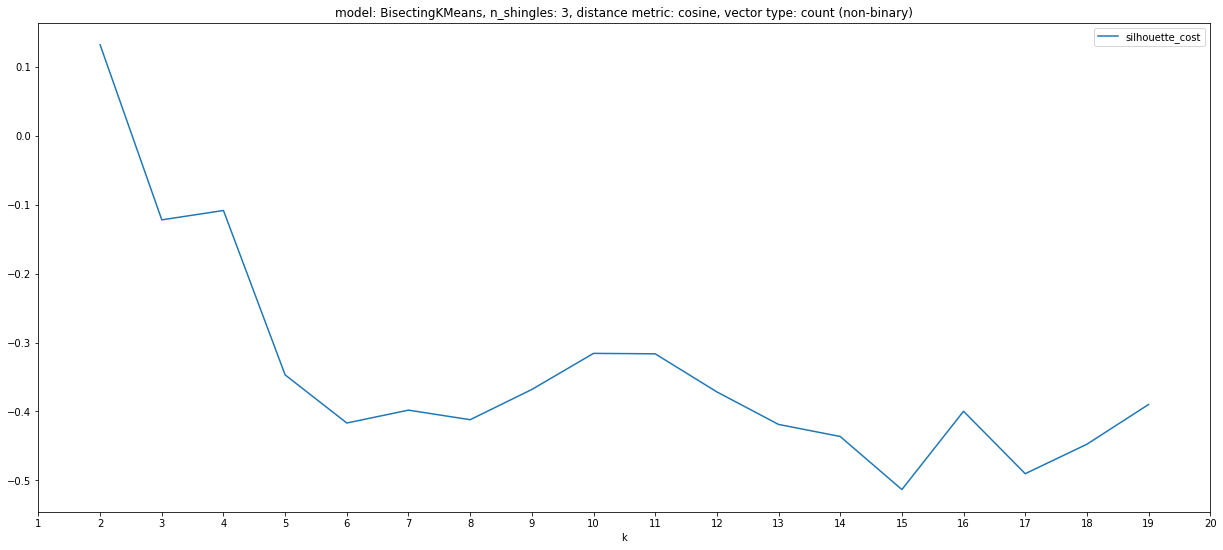

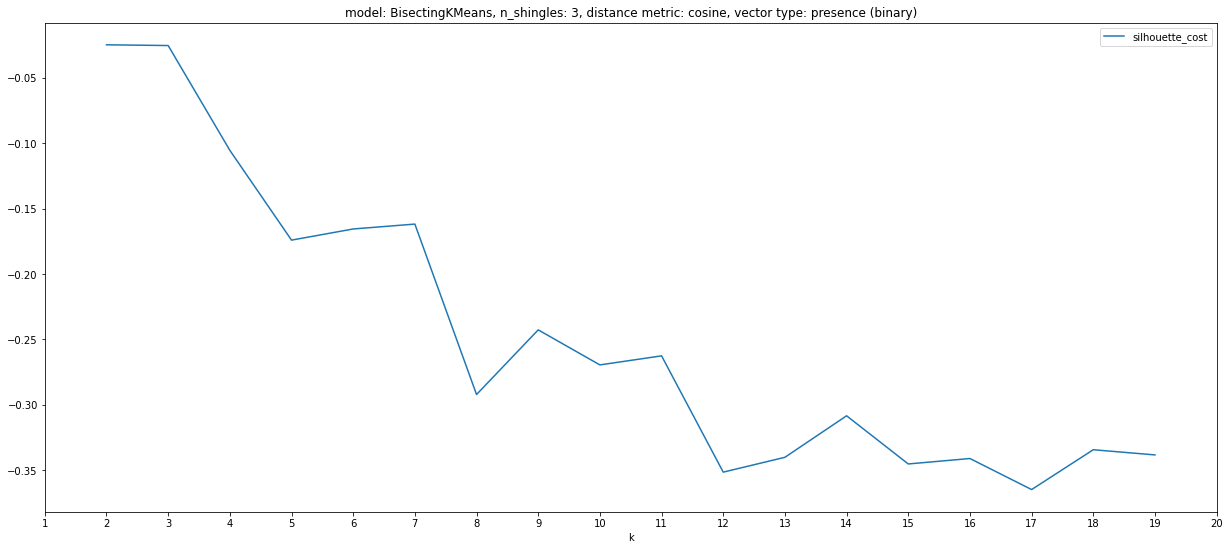

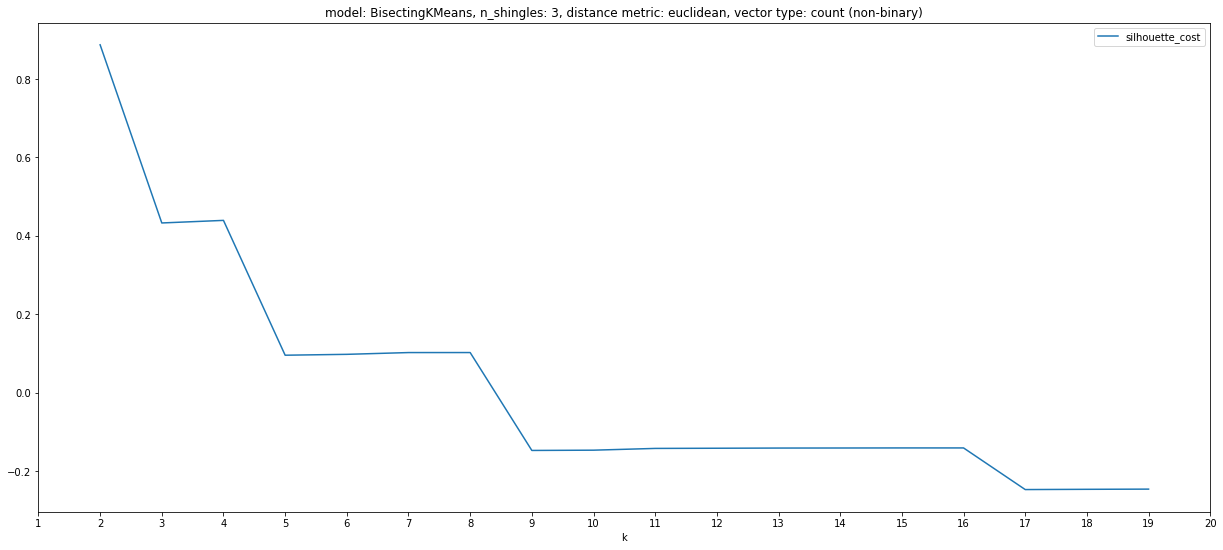

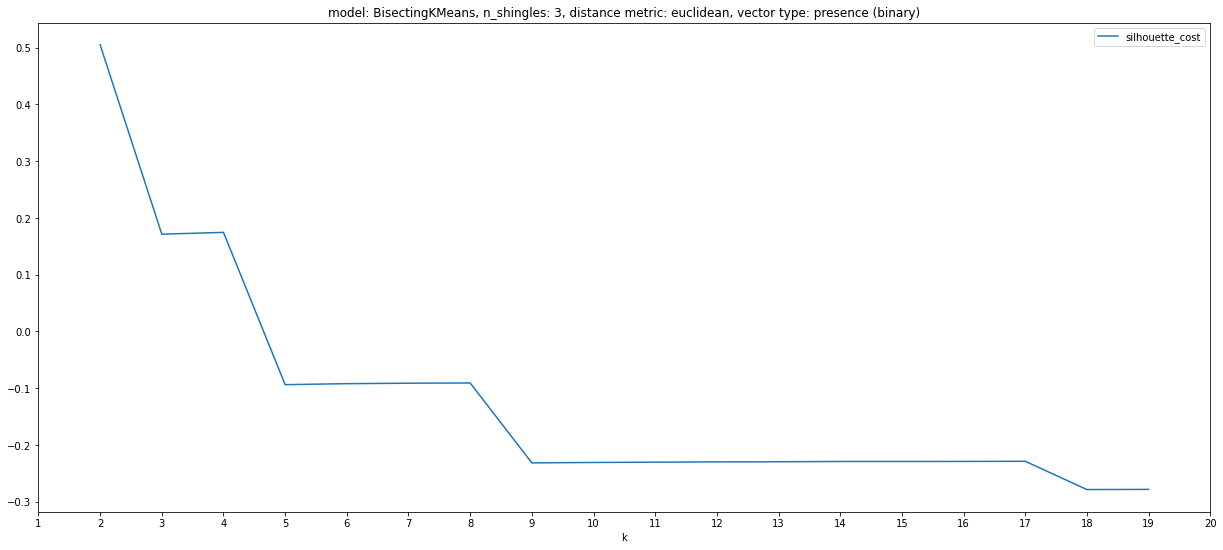

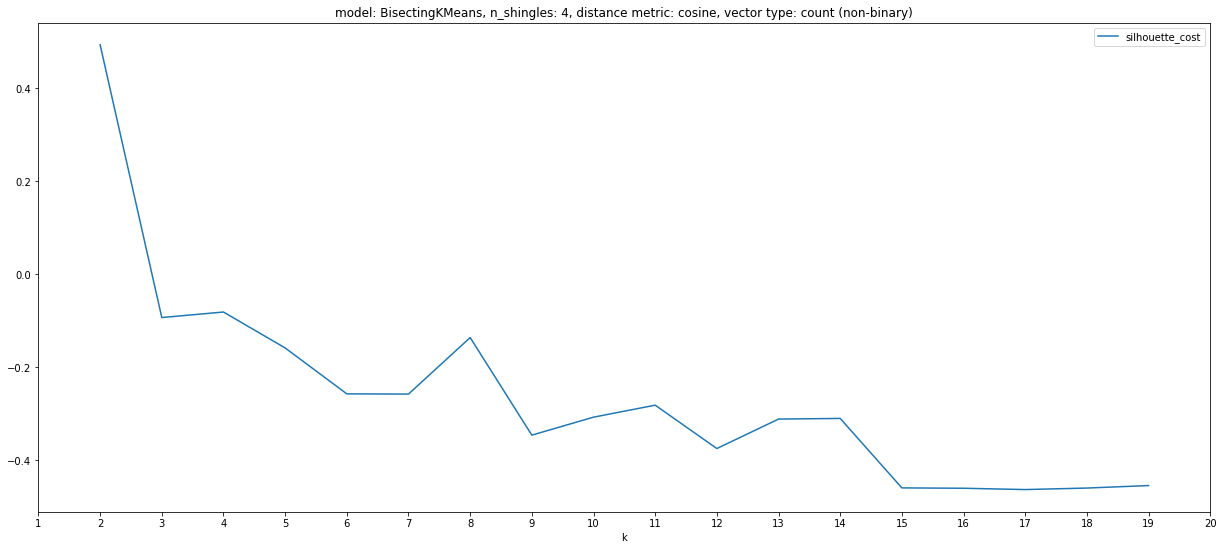

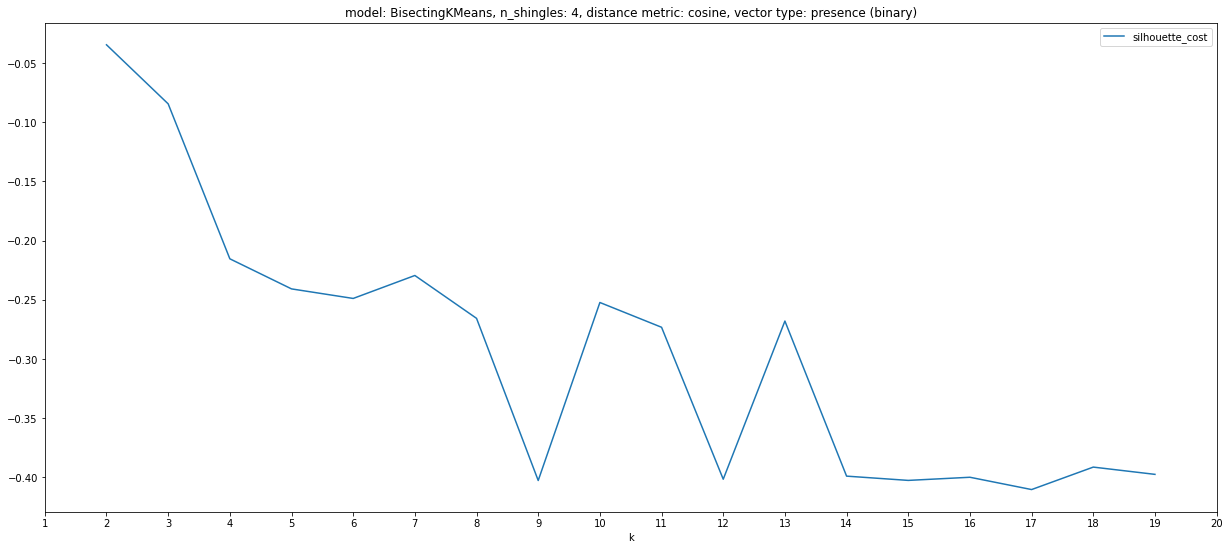

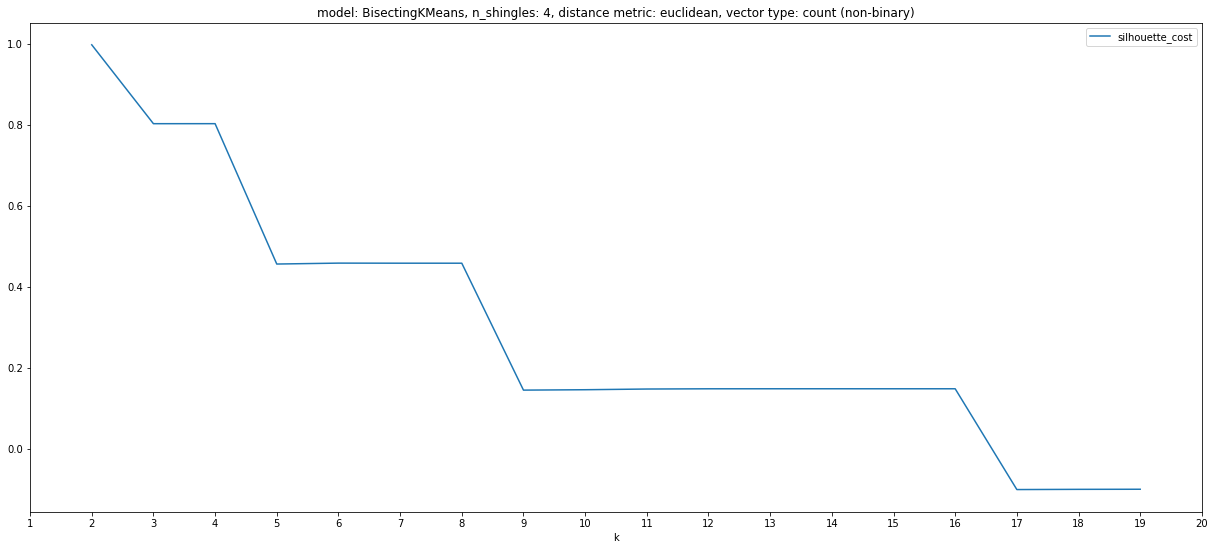

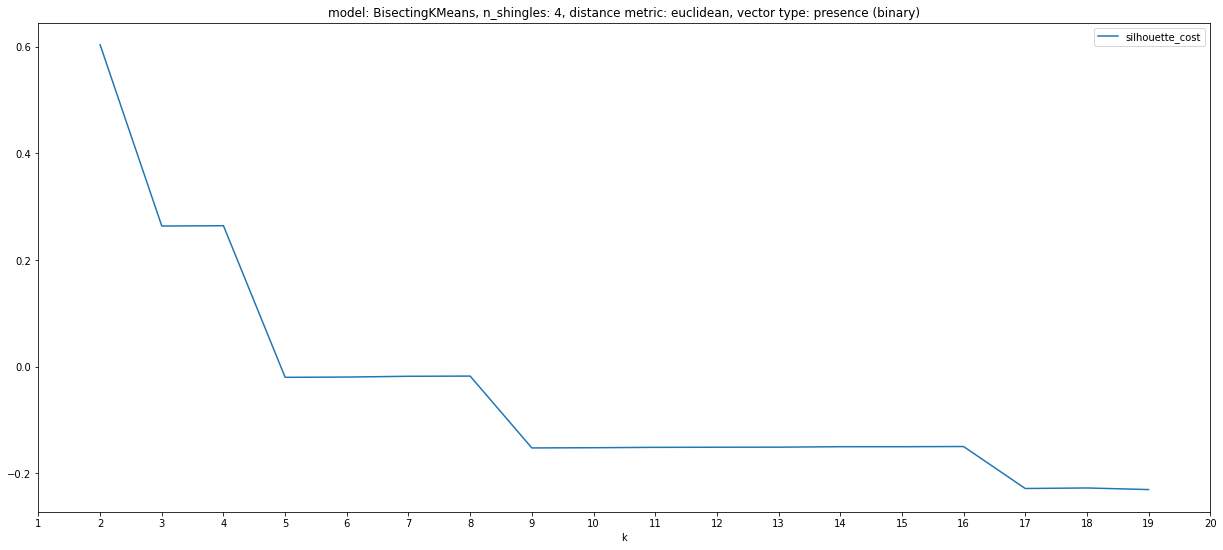

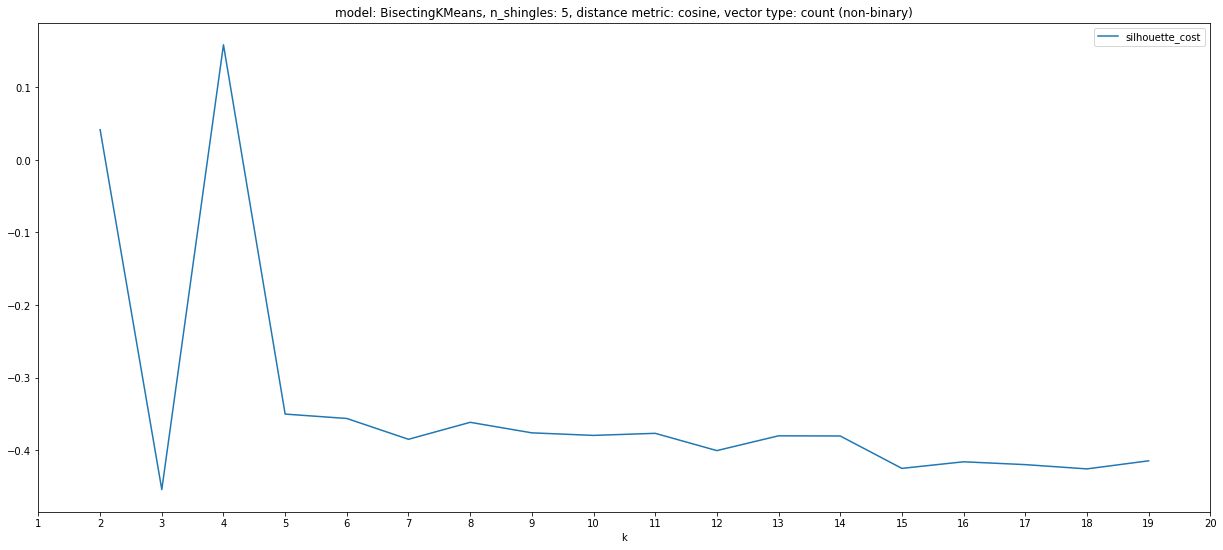

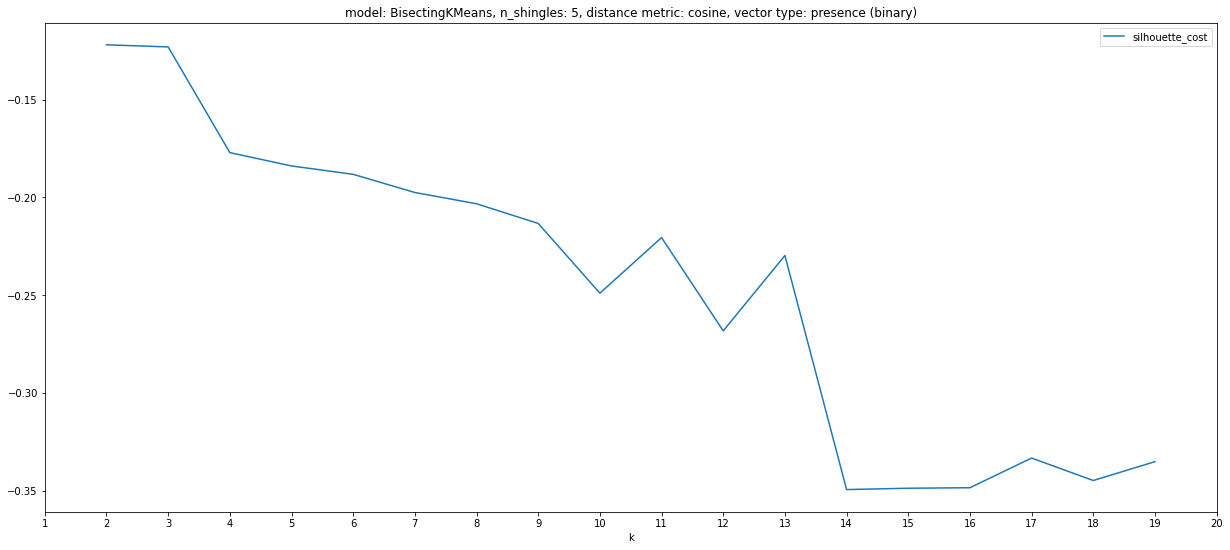

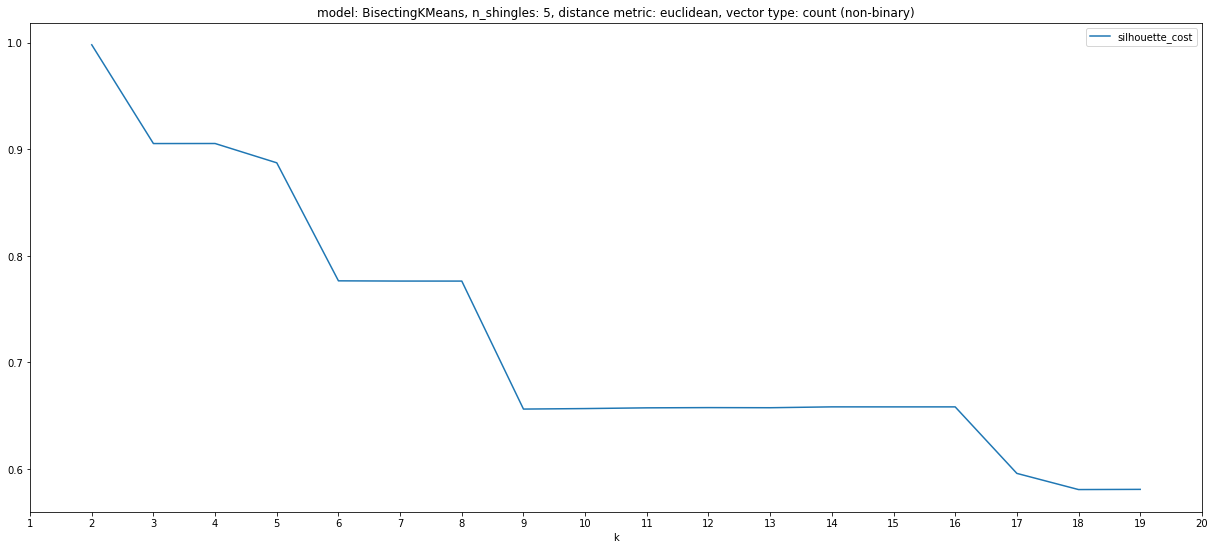

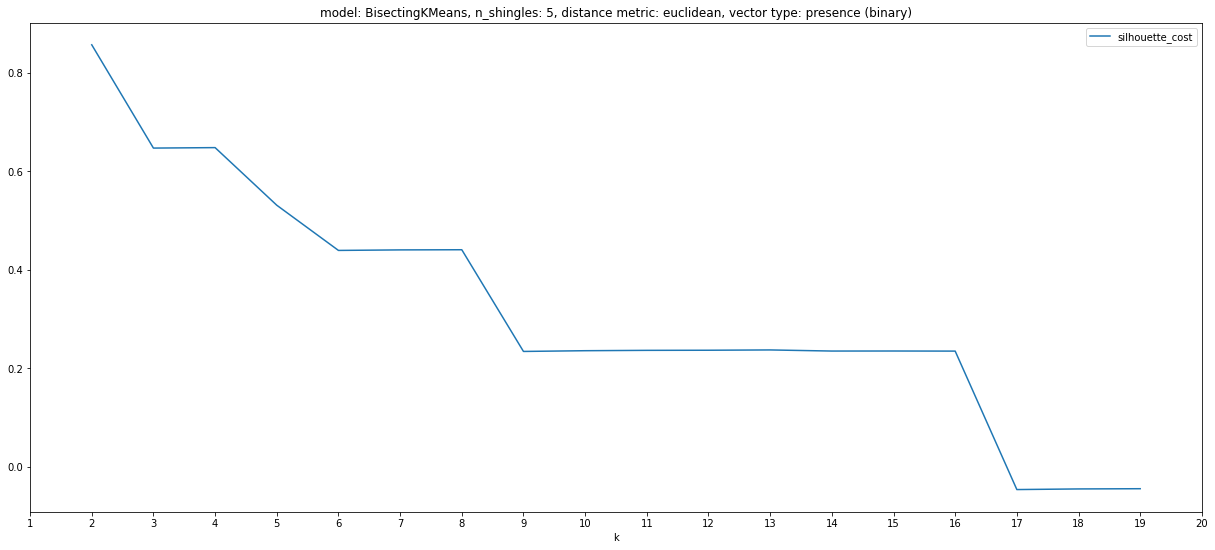

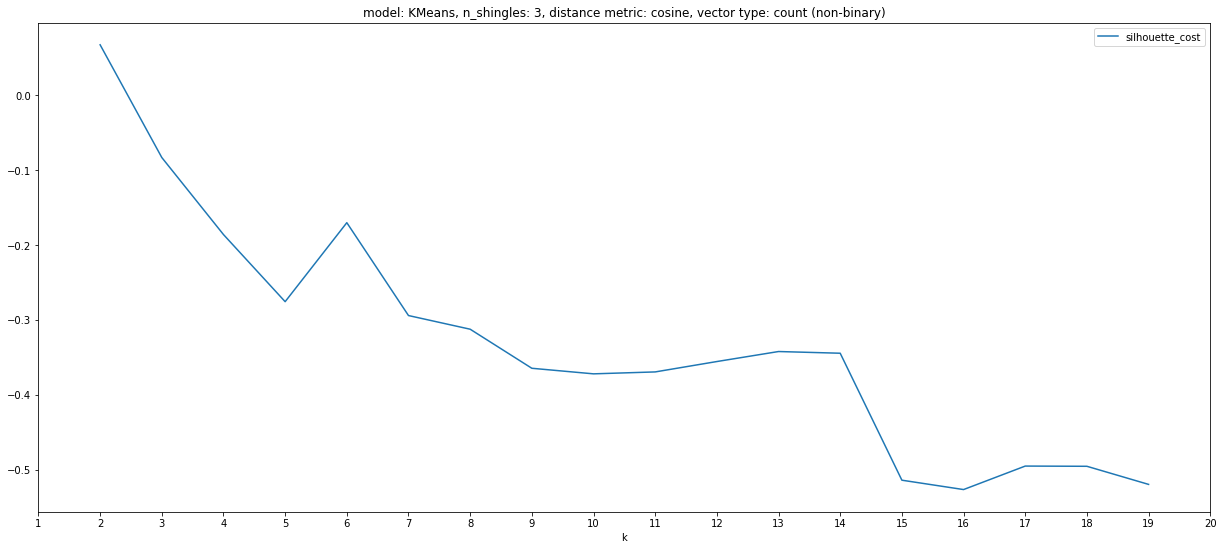

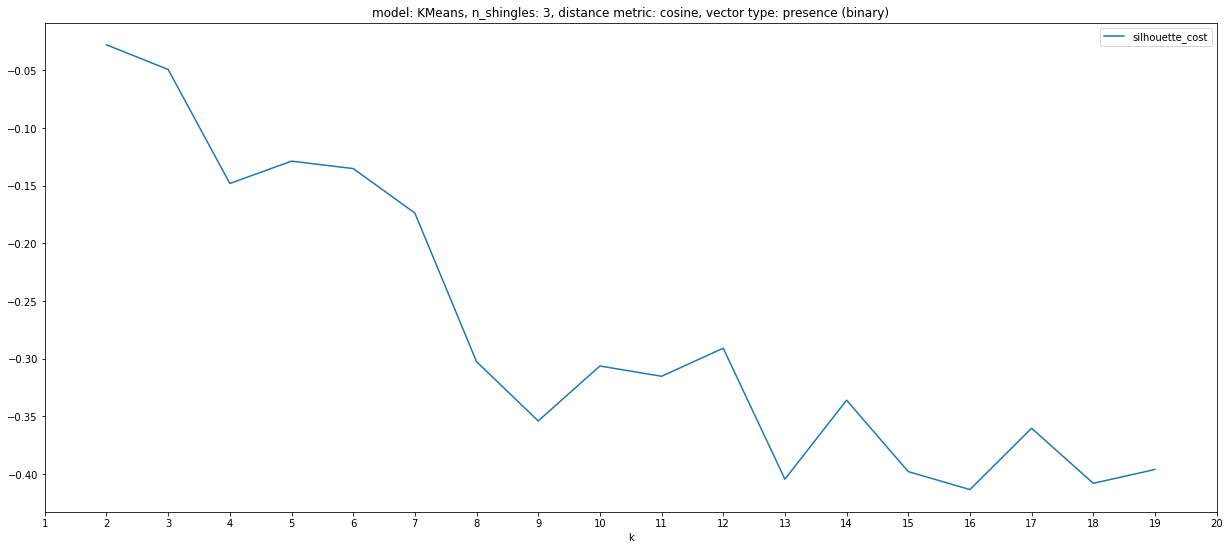

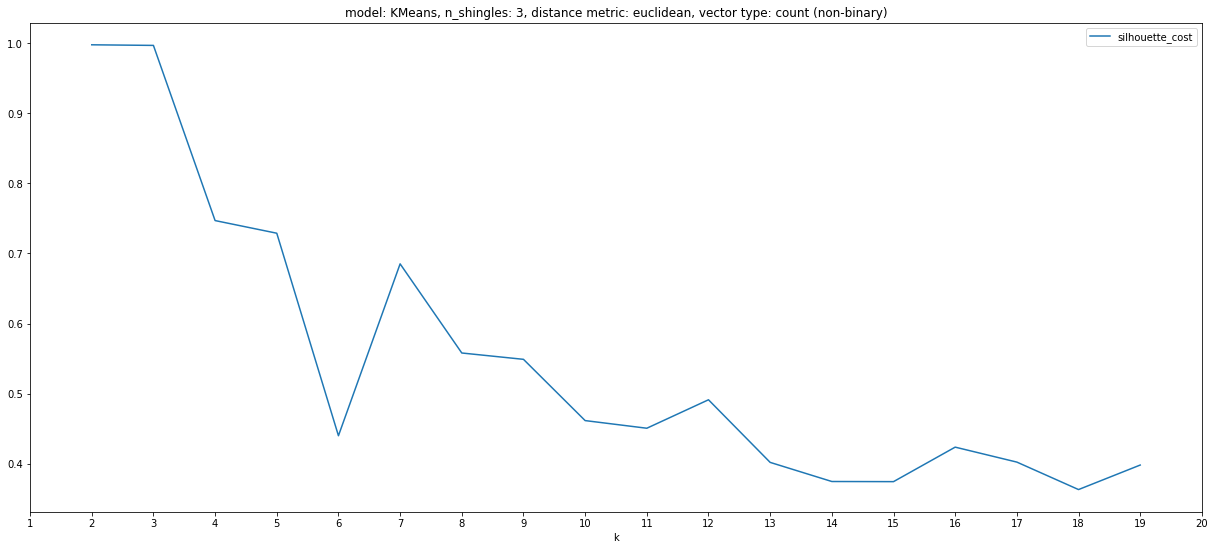

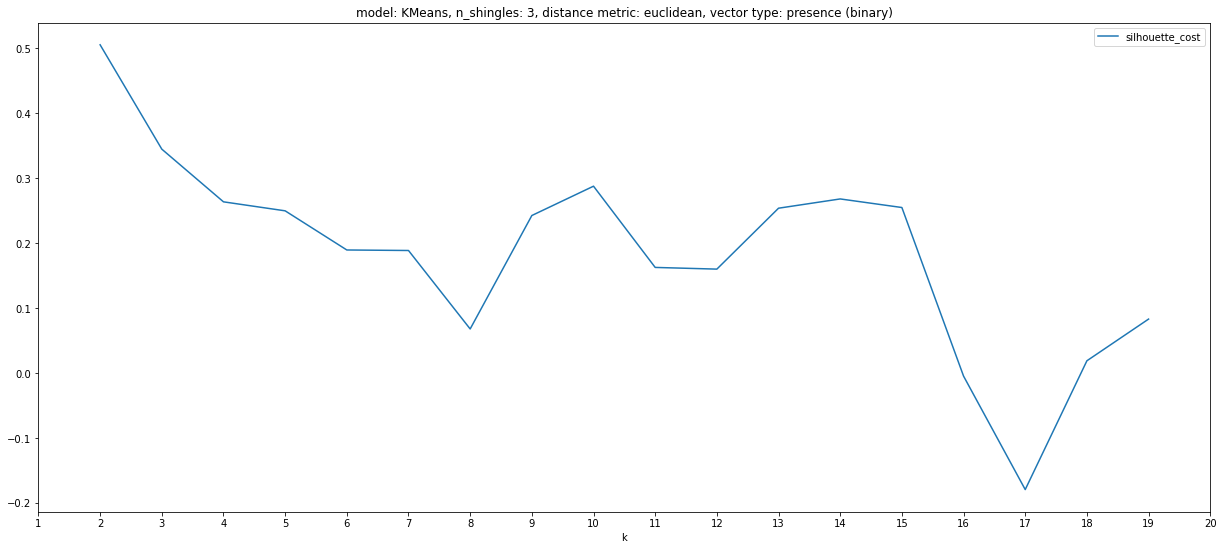

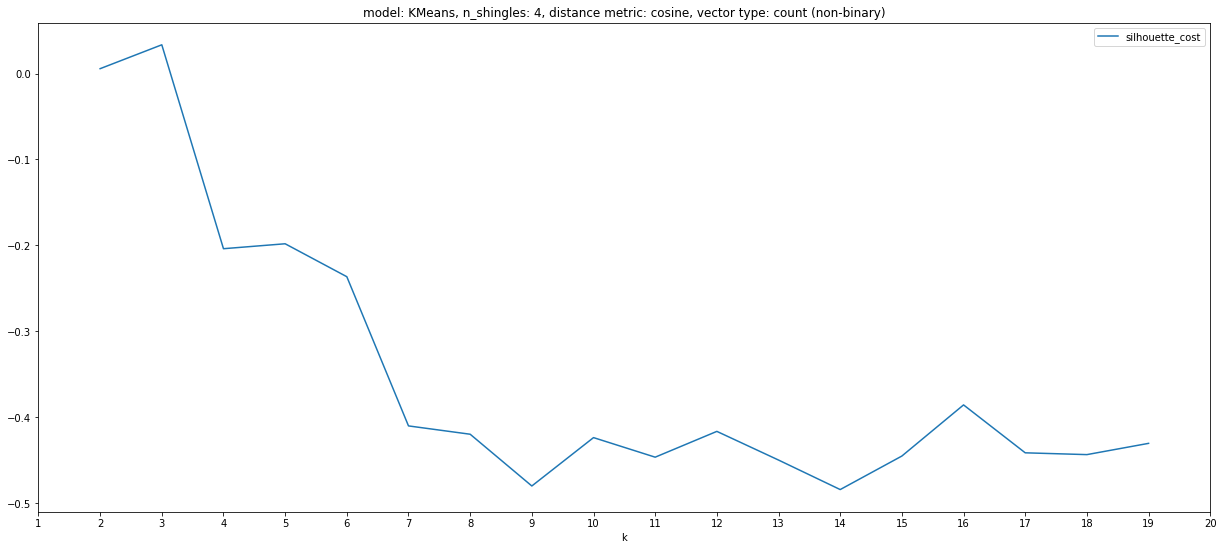

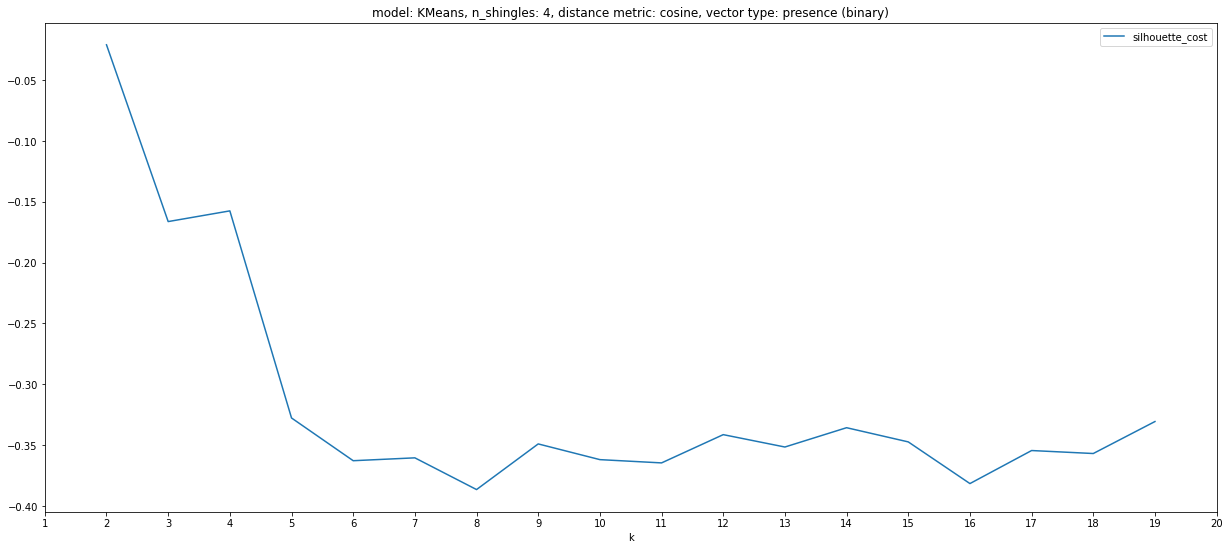

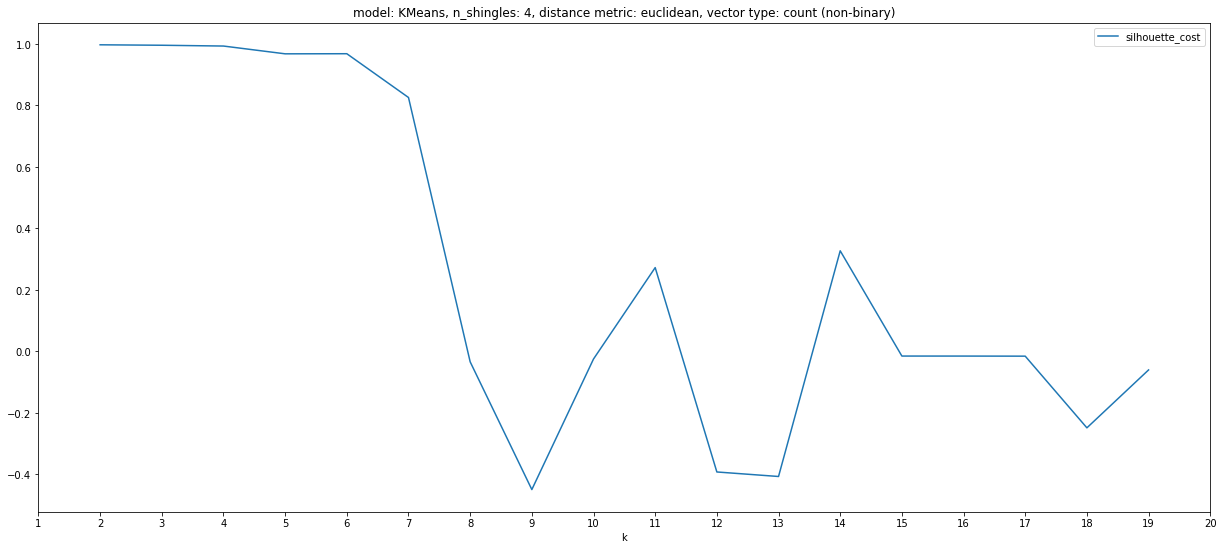

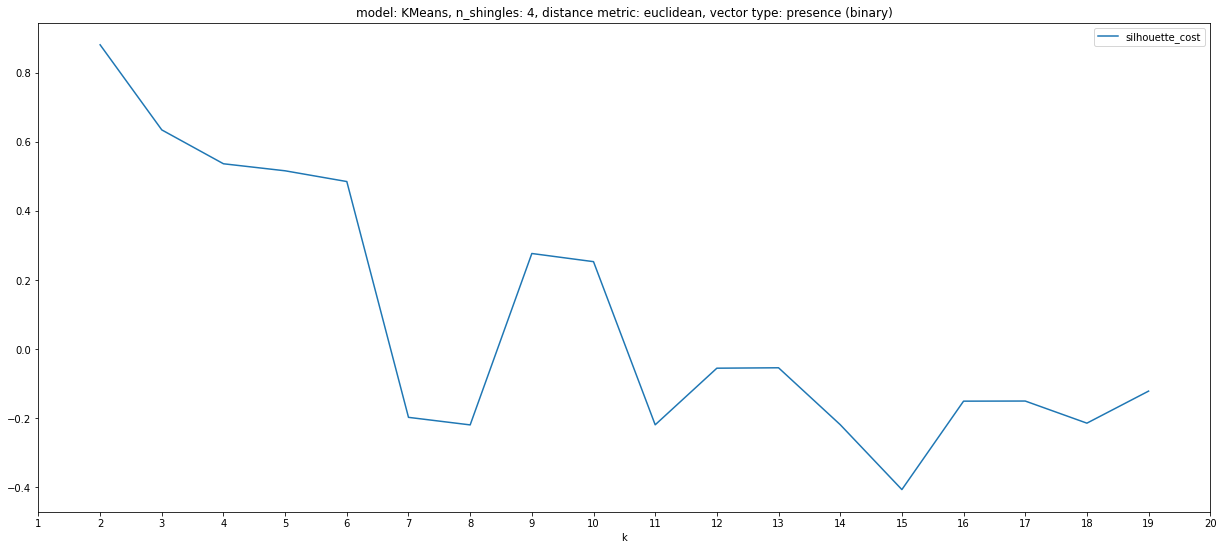

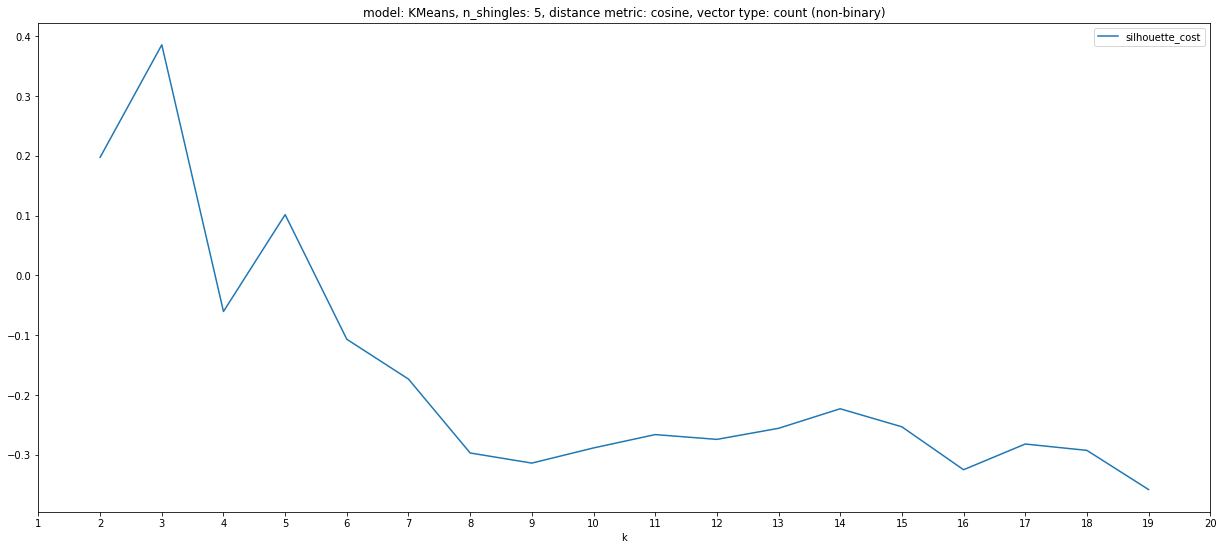

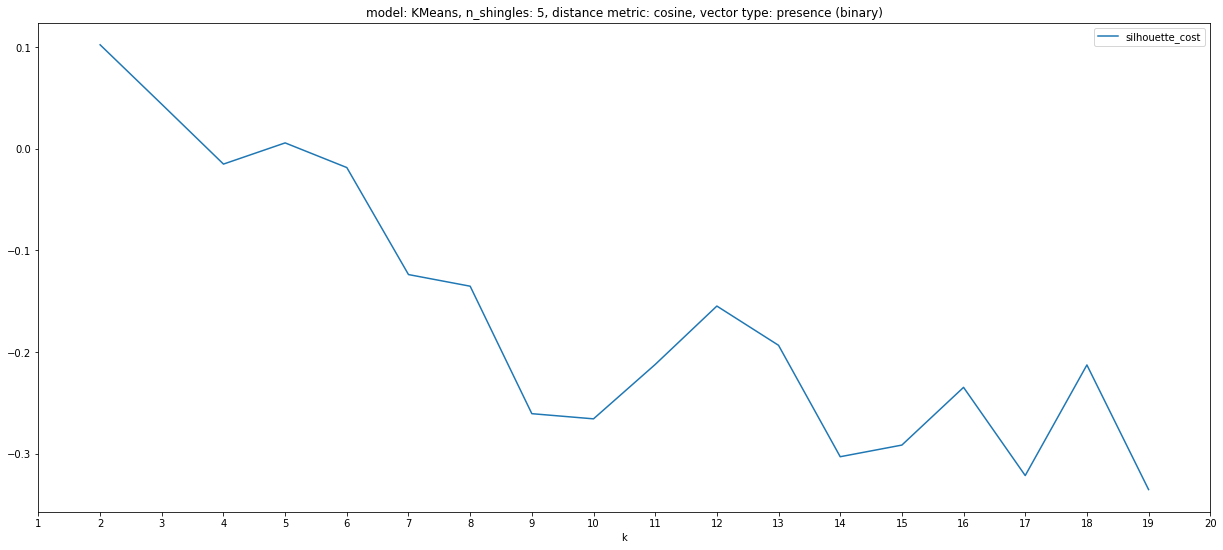

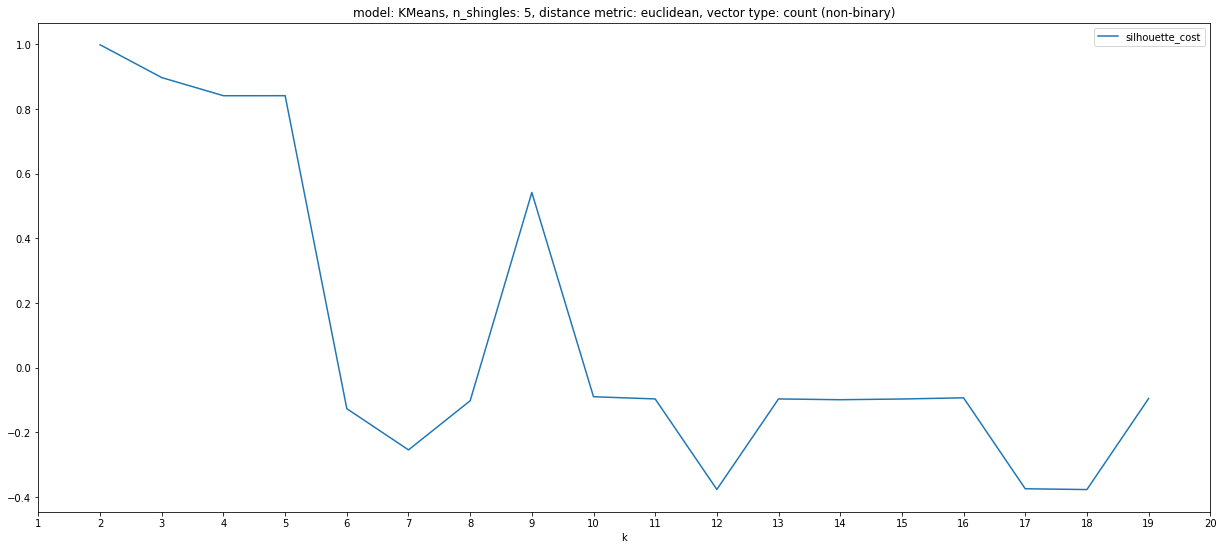

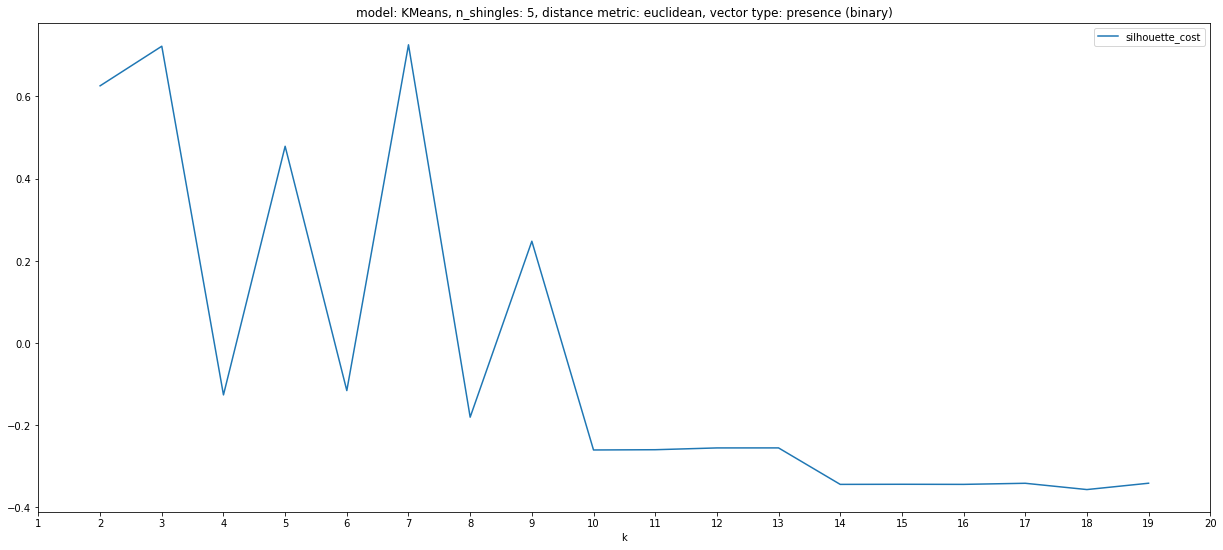

In [6]:
for idx, experiment_df in df.groupby(['model', 'n_shingles', 'distance', 'binary_vectors']):
    vector_type = 'presence (binary)' if idx[3] else 'count (non-binary)'
    title = f"model: {idx[0]}, n_shingles: {idx[1]}, distance metric: {idx[2]}, vector type: {vector_type}"
    experiment_df = experiment_df.sort_values(by='k', ascending=True)
    experiment_df.plot(
        "k", "silhouette_cost", 
        title=title, figsize=(21,9), xticks=list(range(1,21))
    )
    plt.show()
    plt.close()

##### Initial observations

1. For euclidean distance models, k≤7 yields significantly better results than larger values of k.
2. There is significant variance in silhouette scores across k for euclidean models - this is expected,
   as intuition suggests that this metric is less meaningful for comparing ngrams of variable-length sequences.
3. As expected, models trained on data that used 4 or 5 shingles achieve better silhouette scores.
4. Silhouette scores of KMeans and BisectingKMeans are similar, which is also expected.
5. Cosine-based models rarely have silhouette scores greater than 0, and their results are more consistent,
   so we'll give them a closer look to choose optimal set of hyperparameters.

We will validate these observations by taking a closer look at the cosine-based models:

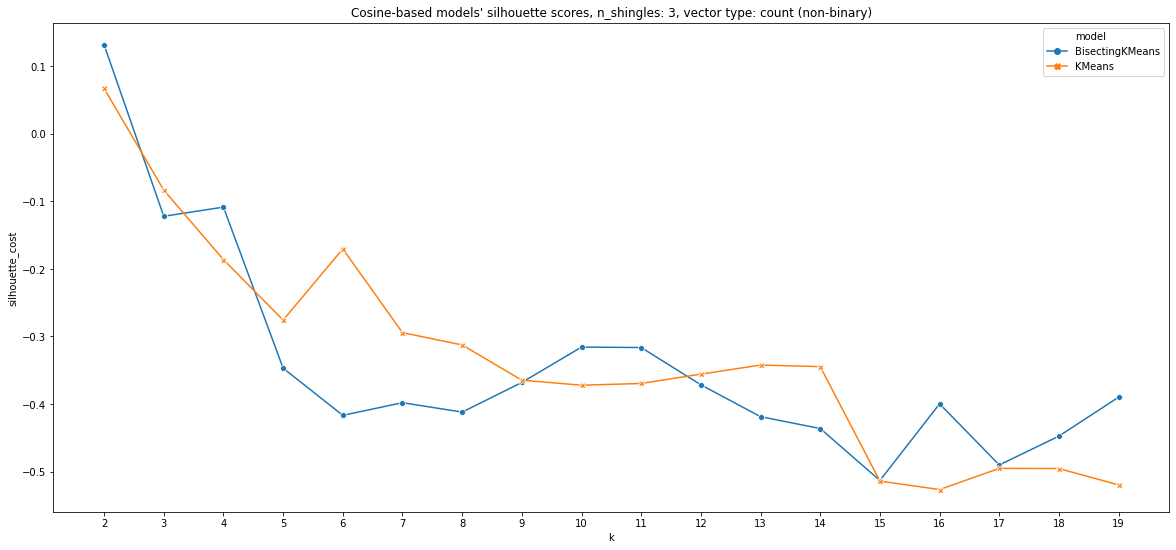

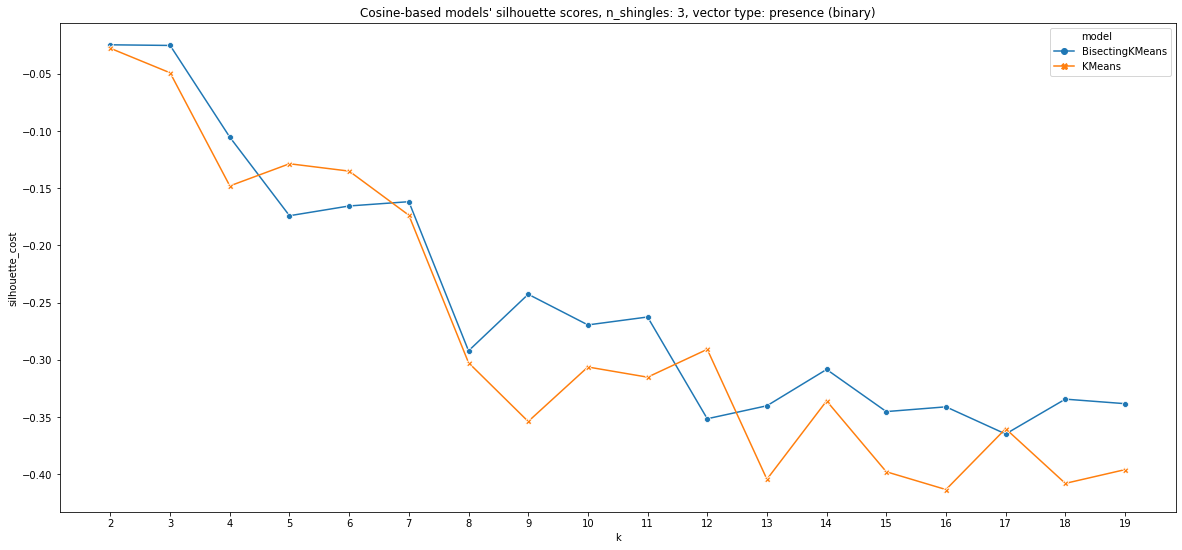

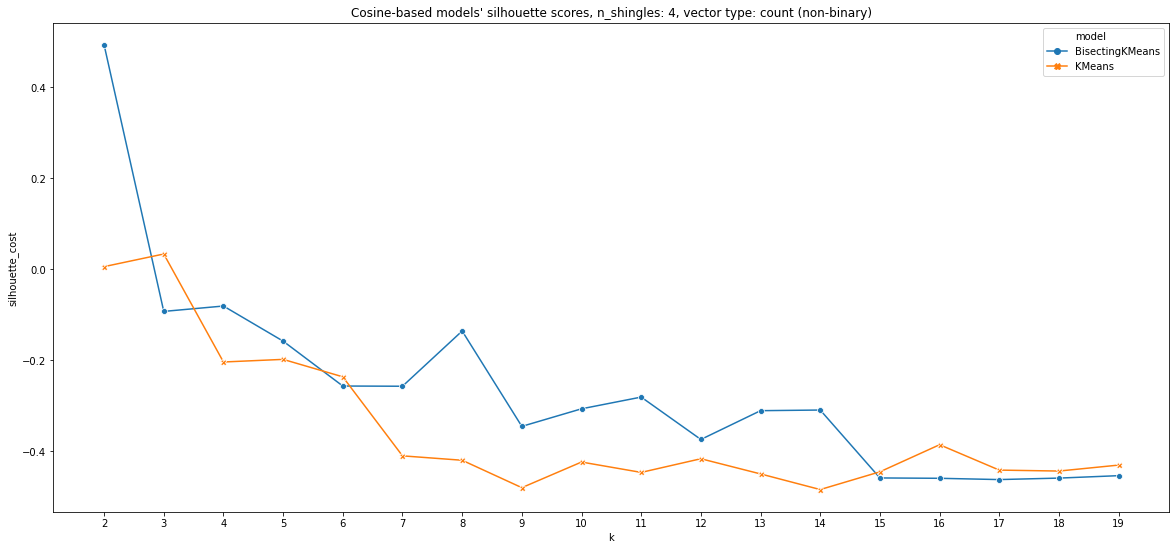

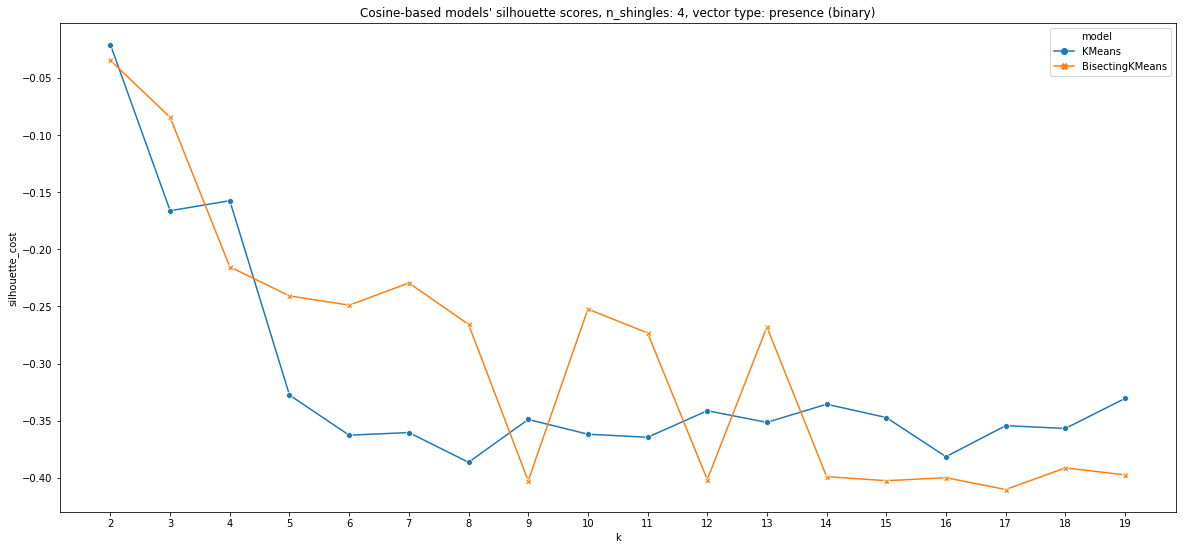

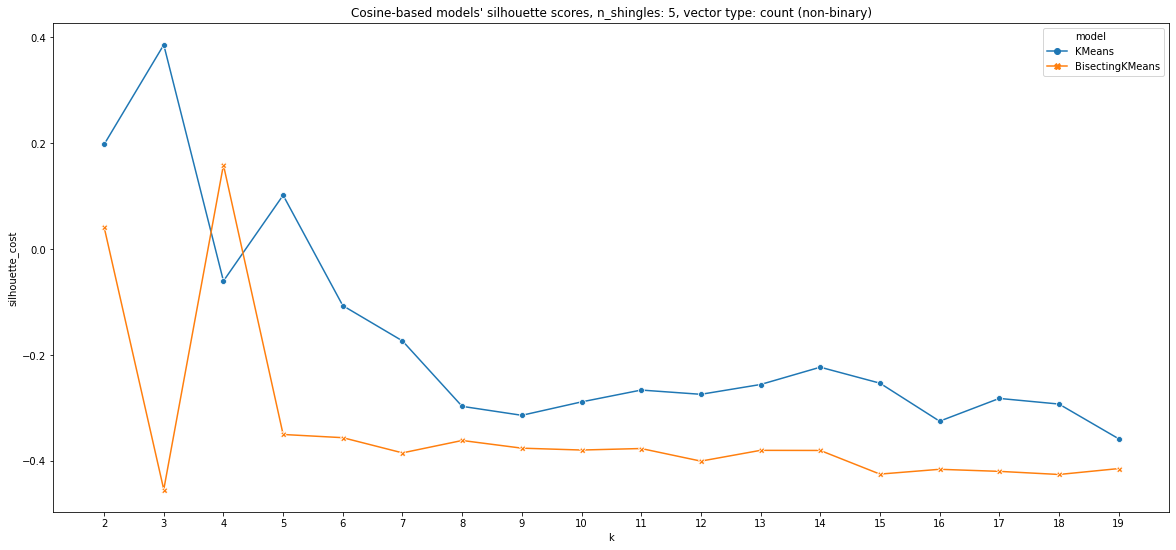

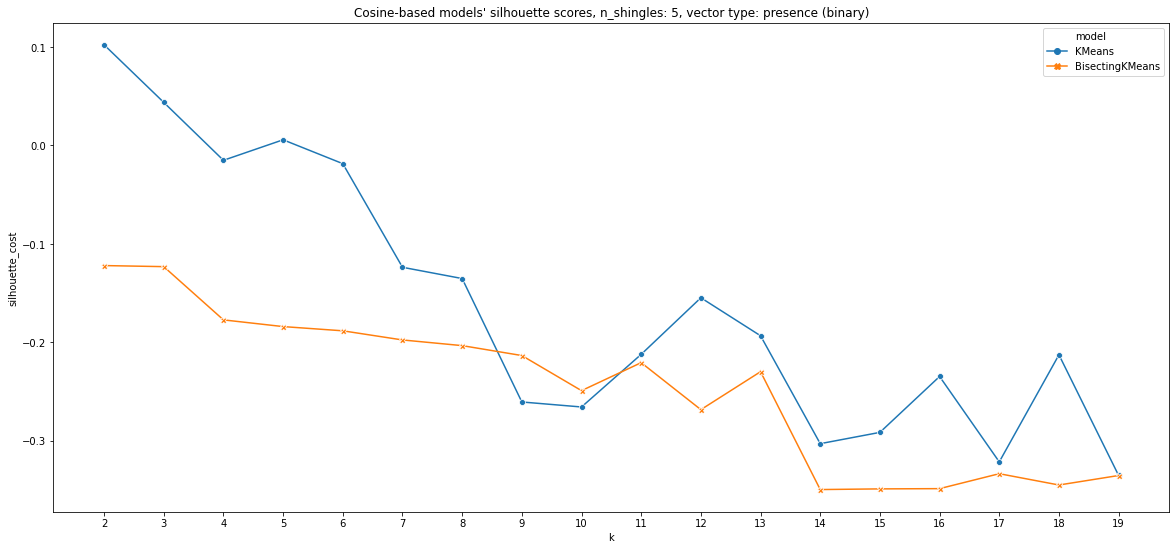

In [21]:
import seaborn as sns

cosine_df = df[df['distance'] == 'cosine']
for idx, experiment_df in cosine_df.groupby(['n_shingles', 'binary_vectors']):
    experiment_df = experiment_df.sort_values(by='k', ascending=True)

    plt.figure(figsize=(20,9))
    plt.xticks(list(range(1,21)))
    vector_type = 'presence (binary)' if idx[1] else 'count (non-binary)'
    title = f"Cosine-based models' silhouette scores, n_shingles: {idx[0]}, vector type: {vector_type}"
    plt.title(title)

    sns.lineplot("k", "silhouette_cost", hue="model", style="model", data=experiment_df, markers=True, dashes=False)
    plt.show()
    plt.close()

##### Additional observations

We can also notice, that silhouette scores for models that use count-based vectors are better.
This is expected, as they carry more information and are also more suited for cosine similarity metric.

Also, `KMeans` performs slightly better than `BisectingKMeans` - for simplicity sake we'll just focus
on the standard `KMeans` model, as their behaviour is quite similar.

We still need to take a look at the distance scores from the models in order to perform a final selection of k

### Distance scores

Finally, we'll use the traditional "elbow" method on the distance scores to select the optimal value of k.

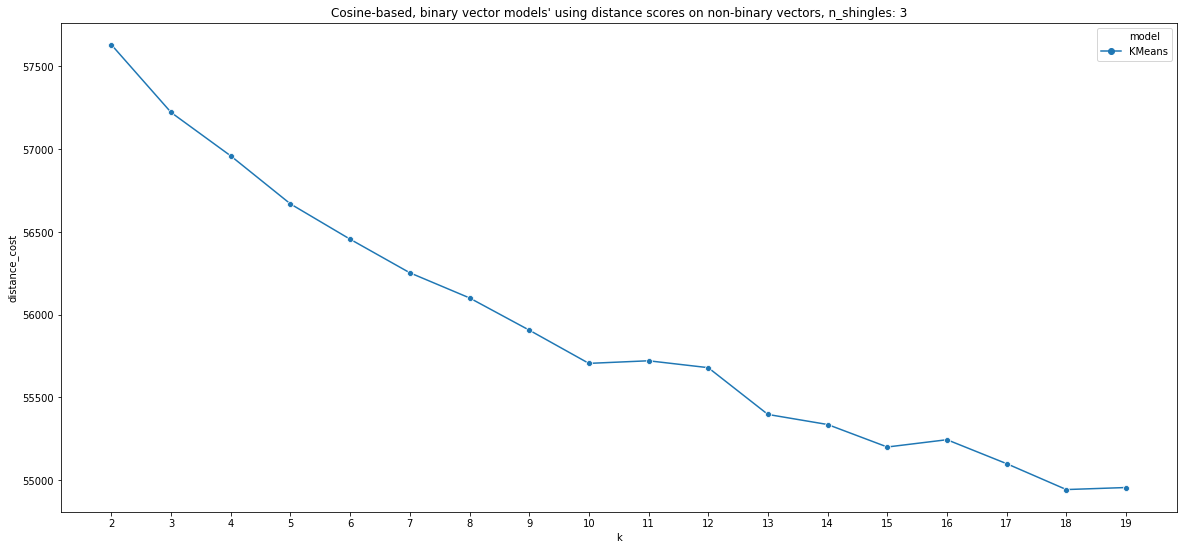

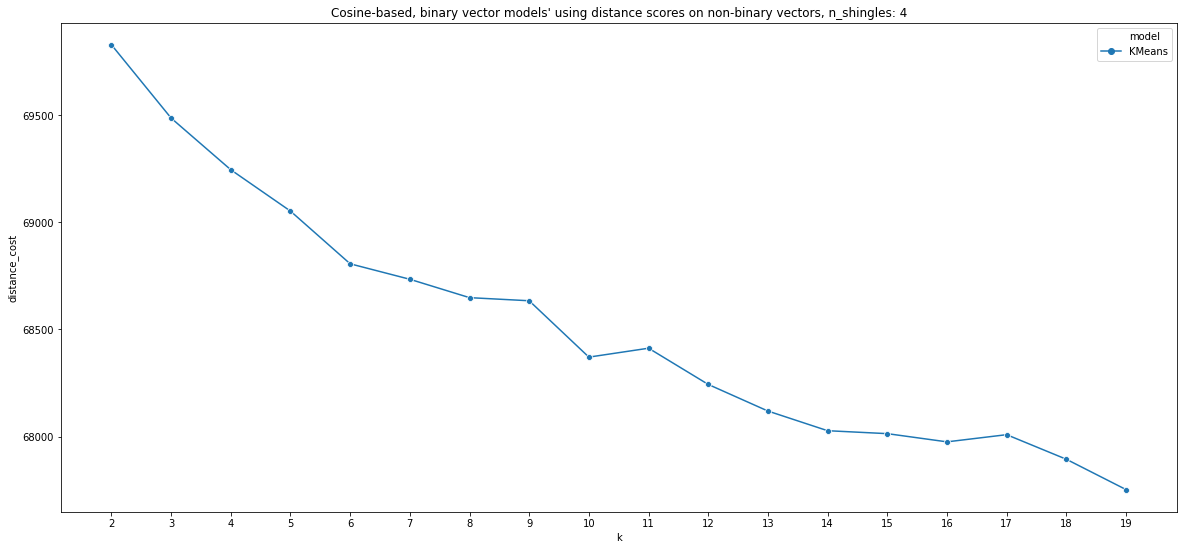

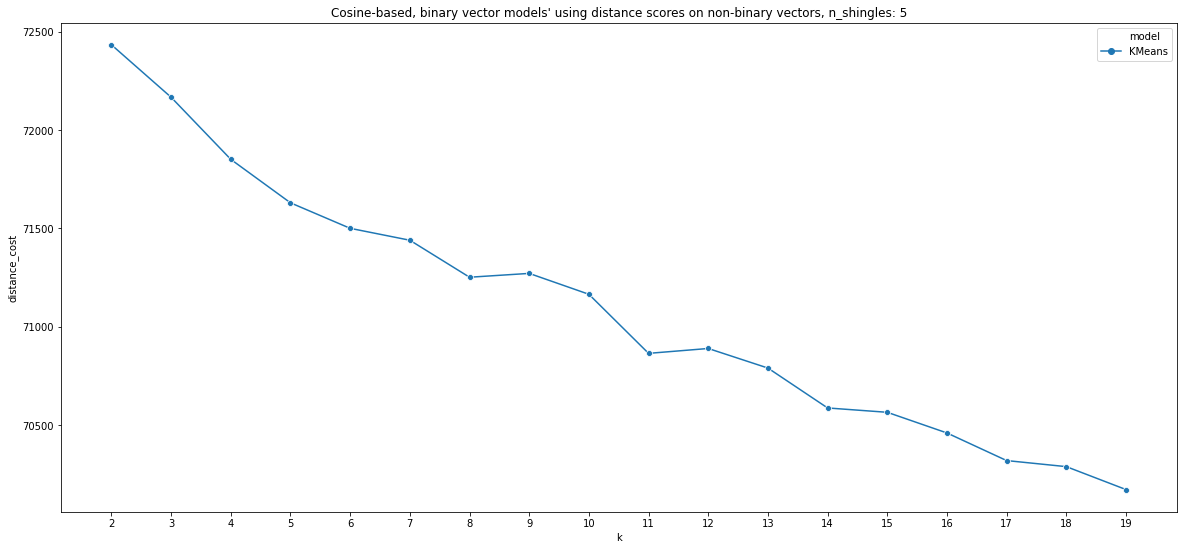

In [31]:
final_df = df[(df['distance'] == 'cosine') & (df['binary_vectors'] == False) & (df['model'] == 'KMeans')]

for idx, experiment_df in final_df.groupby(['n_shingles']):
    experiment_df = experiment_df.sort_values(by='k', ascending=True)

    plt.figure(figsize=(20,9))
    plt.xticks(list(range(1,21)))
    title = f"Cosine-based, binary vector models' using distance scores on non-binary vectors, n_shingles: {idx}"
    plt.title(title)

    sns.lineplot("k", "distance_cost", hue="model", style="model", data=experiment_df, markers=True, dashes=False)
    plt.show()
    plt.close()

### Optimal number of clusters

It seems that for 3- and 4-shingles optimal number of clusters can be 2, 3 or 4.

For 5-shingles the "elbow" seems to be on 4 or 5 - that said, the curve is also quite flat,
so it may as well be 2.

My gut tells me that 2 is the optimal value, that said I would need to consult this with domain experts
before making any serious conclusions.